# Проект: выявление токсичных комментариев

**Цель** - обучить модель-классификатор, которая будет выбирать среди комментариев токсичные и отправлять их на модерацию.

Достаточным качеством модели будет **F1** на тестовой выборке = *0.75*.

---

## 1. Первичное изучение и предобработка данных

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import notebook
from IPython.display import display
import warnings
import joblib

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [2]:
# Откроем файл
data = pd.read_csv('../../../toxic_comments/datasets/toxic_comments.csv')

In [3]:
# Какой размер у датасета?
data.shape

(159571, 2)

In [4]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Посмотрим, соответствует ли единица в целевом признаке токсичным комментариям.

In [5]:
data.query('toxic == 1').head()

,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1


Всё ясно: *1* - токсичный комментарий, *0* - обычный.

Выделим из данных корпус и целевой признак.

In [6]:
# Корпус
corpus = data.text
corpus.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: text, dtype: object

In [7]:
# Целевой признак
target = data.toxic.values
target[:5]

array([0, 0, 0, 0, 0])

Текст грязный не только по смыслу, но и по наличию в нём символов. Попытаемся извлечь из этого пользу. Выделим столбец, в котором будет указано количество восклицательных знаков в тексте. Не факт, что это поможет (восклицательные знаки могут содержаться и в положительных текстах), но мы попробуем. 

In [8]:
exclamations = corpus.apply(lambda x: x.count('!')).rename('num_exclamations')
exclamations.head()

0    0
1    1
2    0
3    0
4    0
Name: num_exclamations, dtype: int64

Теперь удалим символы из текста. Числа оставим, потому что они **могут что-то означать**: например, WW2 - Вторая Мировая Война.

In [9]:
import re

In [10]:
def remove_symbols(text):
    return re.sub(r'[\W]\s*', ' ', text).lower()

Убедимся, что функция работает так, как нам нужно.

In [11]:
# Возьмём произвольный текст
some_text = data.at[42, "text"]
print(f'before:\n\n{some_text}\n')
print(f"after:\n\n{remove_symbols(some_text)}")

before:

You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!

after:

you are gay or antisemmitian archangel white tiger meow greetingshhh uh there are two ways why you do erased my comment about ww2 that holocaust was brutally slaying of jews and not gays gypsys slavs anyone   1  if you are anti semitian than shave your head bald and go to the skinhead meetings 2  if you doubt words of the bible tha

Прекрасно. Теперь преобразуем подобным образом весь корпус.

In [12]:
corpus = corpus.apply(remove_symbols)

In [13]:
corpus.head()

0    explanation why the edits made under my userna...
1    d aww he matches this background colour i m se...
2    hey man i m really not trying to edit war it s...
3     more i can t make any real suggestions on imp...
4    you sir are my hero any chance you remember wh...
Name: text, dtype: object

Отлично. Будет хорошей идеей **лемматизировать** слова, чтобы при векторизации похожие слова объединились. Но мы будем делать это прямо во время обучения.

---

## 2. Обучение моделей

### Кодирование признаков
Мы закодируем признаки тремя разными способами и выясним, что даст наилучшее качество:
- Мешок слов
- TF-IDF-кодирование
- BERT-эмбеддинги

Напишем небольшой пайплайн, который:
- Примет на вход данные
- Лемматизирует их (если нужно)
- Векторизует тексты в корпусе
- Выполнит кросс-валидацию модели,
- Измерит качество предсказаний на тестовой выборке.

Мы будем использовать его с `CountVectorizer` и `TfidfVectorizer`, а нашей моделью будет логистическая регрессия. Приоритетной метрикой для нас будет F1 при кросс-валидации **на обучающей выборке**.

In [14]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import f1_score
import nltk
from nltk.corpus import stopwords
from functools import partial
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy import sparse
from nltk.stem import SnowballStemmer, WordNetLemmatizer


# Обозначим стоп-слова из английского языка
nltk.download('stopwords')
stop_en = stopwords.words('english')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/ivan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ivan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [150]:
from toads.utils import dict_agg

In [17]:
def lemmatize(text, lemm_func):
    """Возвращает лемматизированную строку."""
    return ' '.join(
        list(
            map(lemm_func, text.split())
        )
)

def train_pipeline(model, vectorizer, x, y, with_exclamations=False, lemm_func=None, **vec_kws) -> dict:
    """Обучает модель на данных, преобразованных с помощью объекта vectorizer.
    lemm_func = функция, принимающая слово."""
    global exclamations
    # Лемматизируем, если есть, чем
    if lemm_func:
        print('lemmatizing...')
        x = x.copy().apply(lemmatize, lemm_func=lemm_func)
        
    # Делим на выборки 3:1
    print('splitting into train-test...')
    x_train, x_test, y_train, y_test, exc_train, exc_test = train_test_split(x, y, exclamations, random_state=0, test_size=.25)
    # Проверяем качество деления
    print('data split into shapes:')
    for x in (x_train, x_test, y_train, y_test, exc_train, exc_test):
        print(x.shape)
    # Создаём объект-векторизатор
    vectorizer = vectorizer(**vec_kws)
    # Преобразуем корпус
    print('vectorizing...')
    x_train = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)
    # Если используем восклицательные знаки, добавим один столбец к матрице
    if with_exclamations:
        x_train = sparse.hstack([x_train, exc_train.values.reshape(-1, 1)], format='csr')
        x_test = sparse.hstack([x_test, exc_test.values.reshape(-1, 1)], format='csr')
    display(x_train)
    # Запишем результат кросс-валидации с метрикой F1
    print('cross-validating...')
    output = cross_validate(model, x_train, y_train, cv=3, n_jobs=-1, scoring='f1')
    output['cv_score'] = output['test_score']
    del output['test_score']
    # Добавим F1 на тестовой выборке
    model.fit(x_train, y_train)
    output['test_score'] = f1_score(y_test, model.predict(x_test))
    # Время предсказания нас не интересует
    del output['score_time']
    return dict_agg(output)

# Закрепим корпус и целевой признак, запомним стоп-слова, чтобы не писать это по многу раз
train_vectorized = partial(train_pipeline, x=corpus, y=target, stop_words=stop_en)

#### Мешок слов (Bag of words)
Посчитаем, сколько раз каждое слово встречается в объектах корпуса. Используем для этого `CountVectorizer` из `sklearn`.

In [36]:
%%time
# Базовые параметры
train_vectorized(LogisticRegression(class_weight='balanced'), vectorizer=CountVectorizer)

splitting into train-test...
data split into shapes:
(119678,)
(39893,)
(119678,)
(39893,)
(119678,)
(39893,)
vectorizing...


<119678x159224 sparse matrix of type '<class 'numpy.int64'>'
	with 3364948 stored elements in Compressed Sparse Row format>

cross-validating...
CPU times: user 19.3 s, sys: 386 ms, total: 19.7 s
Wall time: 14.7 s


{'fit_time': 3.7832704385121665,
 'cv_score': 0.7563500303493876,
 'test_score': 0.7681771487273142}

Средняя F1 при кросс-валидации уже превышает необходимое по условию значение.

In [37]:
%%time
# Со стеммингом
train_vectorized(LogisticRegression(class_weight='balanced'), lemm_func=SnowballStemmer('english').stem, vectorizer=CountVectorizer)

lemmatizing...
splitting into train-test...
data split into shapes:
(119678,)
(39893,)
(119678,)
(39893,)
(119678,)
(39893,)
vectorizing...


<119678x127617 sparse matrix of type '<class 'numpy.int64'>'
	with 3296090 stored elements in Compressed Sparse Row format>

cross-validating...
CPU times: user 2min, sys: 643 ms, total: 2min 1s
Wall time: 1min 56s


{'fit_time': 3.1635937690734863,
 'cv_score': 0.7514767480846776,
 'test_score': 0.761926041783041}

- Результат слегка ухудшился в сравнении с данными без стемминга.
- А вот скорость обучения немного увеличилась: в датасете стало на 22000 слов меньше.
- С другой стороны, гораздо больше времени ушло на то, чтобы выполнить стемминг, и в результате нам пришлось ждать дольше ради меньшего качества.

Пока что у нас нет веской причины использовать стемминг. Узнаем, насколько хорошо сработает лемматизация.

In [38]:
%%time
# С лемматизацией
train_vectorized(LogisticRegression(class_weight='balanced'), lemm_func=WordNetLemmatizer().lemmatize, vectorizer=CountVectorizer)

lemmatizing...
splitting into train-test...
data split into shapes:
(119678,)
(39893,)
(119678,)
(39893,)
(119678,)
(39893,)
vectorizing...


<119678x150180 sparse matrix of type '<class 'numpy.int64'>'
	with 3349273 stored elements in Compressed Sparse Row format>

cross-validating...
CPU times: user 1min 46s, sys: 1.24 s, total: 1min 47s
Wall time: 1min 36s


{'fit_time': 6.428382237752278,
 'cv_score': 0.7501819211180161,
 'test_score': 0.7580845070422536}

- Лемматизация по какой-то причине выполняется быстрее, чем стемминг.
- Однако качество ответов стало ещё хуже.

У нас есть дополнительный признак - количество восклицательных знаков. Попробуем включить его в наши признаки и обучить модель без лемматизации.

In [46]:
%%time
# С восклицательными знаками
train_vectorized(LogisticRegression(class_weight='balanced'), vectorizer=CountVectorizer, with_exclamations=True)

splitting into train-test...
data split into shapes:
(119678,)
(39893,)
(119678,)
(39893,)
(119678,)
(39893,)
vectorizing...


<119678x159225 sparse matrix of type '<class 'numpy.int64'>'
	with 3382155 stored elements in Compressed Sparse Row format>

cross-validating...


{'fit_time': 6.620325406392415,
 'cv_score': 0.7551272997261606,
 'test_score': 0.7634613231837007}

- В качестве конкурента для логистической регрессии интересно будет попробовать модель градиентного бустинга.
- `LightGBM` был бы предпочтителен засчёт своей скорости, но он не справляется с задачей и выдаёт ошибку.
- Поэтому мы воспользуемся `CatBoost`.

Чтобы не повторяться в выполнении кода (очень долго), мы прочитаем результаты работы нашего `CatBoost` из файла, а сам код приложим в виде текста.

```
from catboost import CatBoostClassifier
catboost_results = train_vectorized(CatBoostClassifier(), vectorizer=CountVectorizer)
```

In [32]:
# Результаты работы CatBoost
joblib.load('resources/catboost_results')

{'fit_time': 911.5822908878326,
 'cv_score': 0.7090926009147269,
 'test_score': 0.724812472422415}

Как видим, обучение заняло очень много времени в сравнении с линейной моделью, а качество ответов оказалось недостаточным.

У нас возникла идея обучить наивного Байеса: вполне логично, что наличие определённых слов и делает текст токсичным.

In [34]:
from sklearn.naive_bayes import BernoulliNB

In [35]:
%%time
train_vectorized(BernoulliNB(), vectorizer=CountVectorizer)

splitting into train-test...
data split into shapes:
(119678,)
(39893,)
(119678,)
(39893,)
(119678,)
(39893,)
vectorizing...


<119678x159224 sparse matrix of type '<class 'numpy.int64'>'
	with 3364948 stored elements in Compressed Sparse Row format>

cross-validating...
CPU times: user 7.21 s, sys: 454 ms, total: 7.66 s
Wall time: 9.25 s


{'fit_time': 0.25626373291015625,
 'cv_score': 0.43786055380977706,
 'test_score': 0.6656612878902126}

Байес обучился молниеносно, но качество ответов не удовлетворяет нашему условию. Возможно, что на более простых текстах такая модель оказалась бы исключительно эффективной.

#### Промежуточный вывод
- Логистическая регрессия и мешок слов дают **достаточную F1** на тестовой выборке и при кросс-валидации, но важно понимать: малейший шум - и F1 будет ниже 0.75.
- Лемматизация и стемминг пока что **не оправдали себя**, как и восклицательные знаки в качестве признака.
- Классификатор CatBoost учится очень долго и при этом оказывается менее эффективным: такой расклад не окупает затраченное время.
- Наивный Байес даёт не очень хороший результат, но зато работает быстрее остальных моделей.

Пришло время попробовать другую технику векторизации.

---

#### TF-IDF
Теперь мы будем пользоваться значением **TF-IDF**, которое послужит своеобразной *количественной* значимостью каждого слова во всём корпусе:
- Чем выше значение, тем более выдающимся то или иное слово будет для корпуса.
- Так мы сможем оценить наиболее экзотичные слова, а часто используемые слова будут иметь меньшую ценность.

In [37]:
%%time
# Базовая TF-IDF
train_vectorized(LogisticRegression(class_weight='balanced'), vectorizer=TfidfVectorizer)

splitting into train-test...
data split into shapes:
(119678,)
(39893,)
(119678,)
(39893,)
(119678,)
(39893,)
vectorizing...


<119678x159224 sparse matrix of type '<class 'numpy.float64'>'
	with 3364948 stored elements in Compressed Sparse Row format>

cross-validating...
CPU times: user 20.8 s, sys: 497 ms, total: 21.3 s
Wall time: 15.5 s


{'fit_time': 3.6435035864512124,
 'cv_score': 0.7479330887211629,
 'test_score': 0.757901596611274}

- Векторизация происходит быстрее, чем с `CountVectorizer`.
- F1 на тестовой выборке достаточная, а вот кросс-валидация заставляет задуматься. И обучение происходит быстрее, чем на BOW. Посмотрим, помогут ли здесь наши восклицательные знаки.

In [38]:
%%time
# С восклицательными знаками
train_vectorized(LogisticRegression(class_weight='balanced'), vectorizer=TfidfVectorizer, with_exclamations=True)

splitting into train-test...
data split into shapes:
(119678,)
(39893,)
(119678,)
(39893,)
(119678,)
(39893,)
vectorizing...


<119678x159225 sparse matrix of type '<class 'numpy.float64'>'
	with 3382155 stored elements in Compressed Sparse Row format>

cross-validating...


{'fit_time': 3.9175167083740234,
 'cv_score': 0.7463850163058016,
 'test_score': 0.7576968780382413}

Как и в предыдущий раз, восклицательные знаки ухудшили предсказания.

In [39]:
%%time
# Пробуем стемминг
train_vectorized(LogisticRegression(class_weight='balanced'), vectorizer=TfidfVectorizer, lemm_func=SnowballStemmer('english').stem)

lemmatizing...
splitting into train-test...
data split into shapes:
(119678,)
(39893,)
(119678,)
(39893,)
(119678,)
(39893,)
vectorizing...


<119678x127617 sparse matrix of type '<class 'numpy.float64'>'
	with 3296090 stored elements in Compressed Sparse Row format>

cross-validating...


{'fit_time': 3.0886523723602295,
 'cv_score': 0.7486729051321889,
 'test_score': 0.7582642403359535}

Результаты слегка улучшились, но средняя F1 при кросс-валидации по-прежнему ниже требуемого значения.

In [40]:
%%time
# Пробуем лемматизацию
train_vectorized(LogisticRegression(class_weight='balanced'), vectorizer=TfidfVectorizer, lemm_func=WordNetLemmatizer().lemmatize, with_exclamations=True)

lemmatizing...
splitting into train-test...
data split into shapes:
(119678,)
(39893,)
(119678,)
(39893,)
(119678,)
(39893,)
vectorizing...


<119678x150181 sparse matrix of type '<class 'numpy.float64'>'
	with 3366480 stored elements in Compressed Sparse Row format>

cross-validating...


{'fit_time': 3.822201728820801,
 'cv_score': 0.7434745940532781,
 'test_score': 0.7518796992481204}

Лемматизация снова сделала хуже, чем при базовых параметрах.

### Выводы и наблюдения
- Пока что мы склоняемся к использованию `CountVectorizer`, потому что с этим способом кодирования признаков средняя F1 при кросс-валидации и F1 на тестовой выборке **не падают ниже** *0.75*, даже если мы что-то делаем с данными.
- Стемминг ухудшил результаты в случае с мешком слов, а с TF-IDF - слегка улучшил. Лемматизация в обоих случаях сделала хуже.
- Положительный аспект стемминга - количество слов при векторизации заметно сокращается, потому что похожие слова считаются как одно. Лемматизация знает больше разных форм слов, поэтому и слов остаётся больше.
- Исходя из вышесказанного, стемминг уместен в том случае, если нам нужен более компактный набор данных.
- Восклицательные знаки как признак не сыграли большой роли для качества предсказаний, и мы установили это опытным путём.
- Пока что **лучший результат** дают ***логистическая регрессия и мешок слов без каких-либо дополнительных действий***.

---

### \*Классификация на эмбеддингах BERT
Посмотрим, получится ли улучшить результаты, если мы преобразуем признаки с помощью модели **BERT**.

In [15]:
import transformers
import torch
from transformers import BertModel, BertConfig

In [16]:
# Загрузим предобученный англоязычный токенизатор
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

У нас ограничена вычислительная мощность, поэтому испытаем данный метод на не очень большой случайной выборке текстов.

In [68]:
# Зададим размер выборки
sample_size = 5000

# Зафиксируем псевдослучайность
r_state=0
# Возьмём случайные объекты из корпуса
corpus_sample = corpus.sample(sample_size, random_state=r_state).reset_index(drop=True)
# Аналогично возьмём случайные ответы
target_sample = pd.Series(target).sample(sample_size, random_state=r_state).reset_index(drop=True)

Воспользуемся функцией для создания BERT-токенов из текстов.

\*У нас возникла проблема с количеством токенов в некоторых текстах корпуса: максимально допустимое число токенов в модели BERT - *512*. Поэтому мы обрежем тексты до 512 токенов.

In [69]:
import logging
# Отключим предупреждения
logging.getLogger('transformers.tokenization_utils').setLevel(logging.ERROR)

In [70]:
def bert_pad(text, max_len=512, attention_mask=True):
    """Выполняет токенизацию с помощью BERT, дополняет короткие объекты нулями до max_len""" 
    # Токенизация
    tokened = tokenizer.encode(text, add_special_tokens=True, max_length=max_len)
    # Заполняем оставшиеся значения нулями
    return np.array(tokened + [0] * (max_len - len(tokened)))

Представим корпус в виде токенов BERT.

In [71]:
# Запишем токены в список
berted = []
for i in tqdm_notebook(iterable=range(corpus_sample.shape[0])):
    berted.append(bert_pad(corpus_sample[i]))

# Соединим в массив
berted = np.vstack(berted)
berted.shape

(5000, 512)

Теперь нам необходимо сделать маску для массива.

In [72]:
att_mask = np.where(berted != 0, 1, 0)
att_mask[0, :80]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Маска создана верно, и мы можем сгенерировать из закодированных слов эмбеддинги с помощью модели BERT.

In [73]:
bert_model = BertModel.from_pretrained('bert-large-uncased')

Преобразуем данные и маску в тензоры для совместимости с PyTorch.

In [74]:
berted_tensor = torch.LongTensor(berted)
display(berted_tensor[:3])
mask_tensor = torch.IntTensor(att_mask)
mask_tensor[:3]

tensor([[ 101, 1045, 4033,  ...,    0,    0,    0],
        [ 101, 1045, 8534,  ...,    0,    0,    0],
        [ 101, 1045, 1049,  ...,    0,    0,    0]])

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)

Будем извлекать из слов эмбеддинги поэлементно. Записывать их будем в файл.

In [75]:
%%time
with open('resources/embeddings', 'w') as embeddings:
    with torch.no_grad():
        for i in notebook.tqdm(range(berted_tensor.shape[0])):
            # Добавляем в список эмбеддинги из батча
            mask_tensor[i]
            bert_model(berted_tensor[i].reshape(1, -1),
                       attention_mask=mask_tensor[i].reshape(1, -1))[0][:, 0, :].numpy().tofile(embeddings, ', ')
            embeddings.write('\n')


CPU times: user 11h 50min 27s, sys: 21min 42s, total: 12h 12min 10s
Wall time: 3h 4min 31s


- Наши пробные BERT-признаки теперь сохранены в файле `embeddings`.
- 5000 объектов заняли три часа, а у нас их в 30+ раз больше: если потребуется обсчитать все объекты, здесь не обойдётся без мощного компьютера.
- Файл с эмбеддингами занимает 107 Мб.

In [169]:
# Загрузим эмбеддинги из нашего файла
bert_features = np.loadtxt('../../embeddings', delimiter=', ')
bert_features.shape

(5000, 1024)

- У нас получилось не так много объектов.
- Качество ответов на тестовой выборке сильно **зависит от случайности**,
- Поэтому мы **получим распределение** F1 кросс-валидацией и проанализируем его.

In [111]:
# Выполним кросс-валидацию
bert_cv = cross_validate(LogisticRegression(class_weight='balanced'),
                         bert_features, target_sample,
                         scoring='f1', cv=25)

In [112]:
# Запишем распределение F1 в переменную
cv_scores = np.array(bert_cv['test_score'])

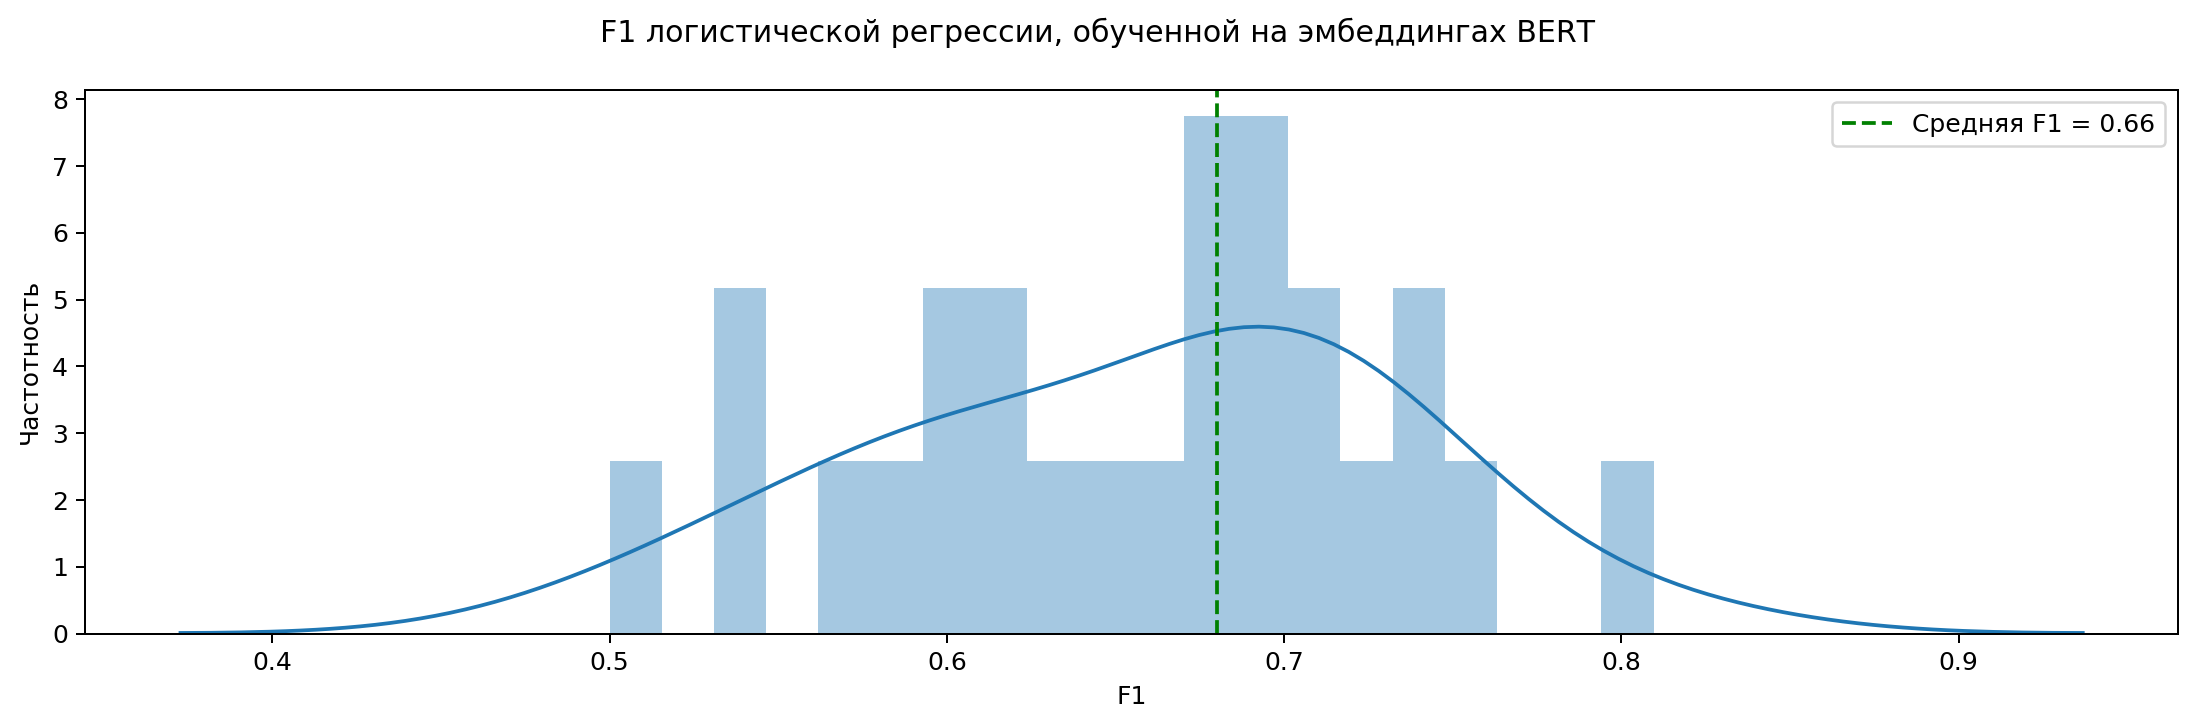

In [113]:
# Нарисуем гистограмму
plt.figure(figsize=(15, 4), dpi=180)
sns.distplot(cv_scores, bins=20)
plt.axvline(np.median(cv_scores), label=f'Средняя F1 = {np.mean(cv_scores):.2}', ls='--', c='g')
plt.xlabel('F1'); plt.ylabel('Частотность')
plt.suptitle('F1 логистической регрессии, обученной на эмбеддингах BERT')
plt.legend()
plt.show()
plt.close()

- Мы попробовали разное количество блоков для кросс-валидации, и средняя F1 оказывается в районе 0.65-0.66.
- Сложно однозначно сказать, даёт обучение на BERT хорошие или плохие результаты: распределение имеет размах в ~0.3.
- Возможно, если бы мы обучили модель на всём наборе данных, а не всего на 5000, наши предсказания превзошли бы все ожидания.
- Сделаем вывод, что BERT - хорошая задумка, но задача, которая перед нами стоит, выполняется при помощи более легковесных и быстрых решений.

---

## 3. Обучение финальной модели

Мы испытали три способа преобразования текстов для машинного обучения, и пока что наиболее надёжным вариантом выглядит логистическая регрессия с преобразованием мешка слов. Но мы не ещё не оптимизировали **гиперпараметры**, а значит, что есть шанс приподнять планку F1.

In [114]:
from sklearn.model_selection import GridSearchCV

In [115]:
# Делим на выборки
xtr_final, xts_final, ytr_final, yts_final = train_test_split(corpus, target, random_state=0, test_size=0.2)
for df in (xtr_final, xts_final, ytr_final, yts_final):
    print(df.shape)

(127656,)
(31915,)
(127656,)
(31915,)


In [116]:
# Векторизуем тексты
cvect = CountVectorizer(stop_words=stop_en)
xtr_final = cvect.fit_transform(xtr_final)
xts_final = cvect.transform(xts_final)

Лемматизацию и восклицательные знаки делать не будем. Эти операции не будут иметь большого смысла.

In [117]:
# Обучаем GridSearch
log_final = GridSearchCV(LogisticRegression(),
                        {'class_weight': ['balanced', None],
                         'solver': ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs'],
                         'C': np.arange(0.1, 1.1, 0.1)},
                         scoring='f1', cv=3)

In [119]:
log_final.fit(xtr_final, ytr_final)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'class_weight': ['balanced', None],
                         'solver': ['liblinear', 'newton-cg', 'sag', 'saga',
                                    'lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
  

In [120]:
# Смотрим на лучший результат кросс-валидации
log_final.best_score_

0.7608562579553576

Впечатляет. Такого уверенного результата на кросс-валидации ещё не было. Теперь на тестовой выборке.

In [121]:
# F1 на тестовой выборке
f1_score(yts_final, log_final.predict(xts_final))

0.7698412698412698

Этим всё сказано.

---

## 4. Общий вывод
- Нашей задачей было обучение модели-классификатора, которая сумеет выявить токсичные комментарии.
- Мы подготовили текст к векторизации, убрав из него все символы с помощью регулярных выражений.
- Испытали два основных подхода к векторизации текстов:
    - **"Мешок слов"** - кодирование встречаемости каждого слова в предложении.
    - **TF-IDF** - частота слова в тексте и его "необычность" во всём корпусе.
- Увидели, как влияет на предсказания **стемминг и лемматизация**. А также их отсутствие.
    - Стемминг даёт небольшой прирост к точности TF-IDF и заметно сокращает количество признаков.
    - Лемматизация не несёт особой пользы, но работает немного быстрее, чем стемминг.
- Мы также выделили количество восклицательных знаков в тексте как **дополнительный признак**, но это практически не повлияло на качество предсказаний.
- В качестве эксперимента мы обучили логистическую регрессию на **эмбеддингах**, полученных с помощью модели BERT.
    - Проблемой стало то, что BERT не работает с объектами длиннее 512 элементов. Поэтому часть данных могла потеряться.
    - Генерация эмбеддингов занимает **огромное количество времени**.
    - F1 логистической регрессии, обученной на эмбеддингах, варьируется в диапазоне от *~0.5* до *~0.8*.
    - **Количество объектов**, которое даёт такой результат, **во много раз меньше**, чем общее число объектов, на котором мы обучали модель с BOW и TF-IDF.

### Итог:
Мы остановились на том, чтобы взять за основу BOW-векторизацию текстов, обучили логистическую регрессию с подбором гиперпараметров и получили ***F1 = 0.769***. Условие проекта выполнено.

---